In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from math import floor
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

from infomap import Infomap, MultilayerNode

In [2]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, window_size, data, **kwargs):
        
        if length < 1: raise ValueError('Object should be a multilayer network with at least 2 layers')
        if size < 3: raise ValueError('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        self.windowsize = window_size
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. Caveat: if you use edge_list only firing neurons are going
        ##                      to be taken ito consideration.
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.multi_array[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.multi_array[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def binarize(self, array):
        n,t = array.shape
        binary_spikes = np.zeros(array.shape)
        for i in range(n):
            for j in range(t):
                if array[i][j] == 0: pass
                else: binary_spikes[i][j] = 1
        return(binary_spikes)
    
    def bin_time_series(self, array, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
        
        binsize = self.windowsize
        n = array.shape[0] # number of neurons
        totalsize = array.shape[1] # total duration of spikes
        gauss_array = np.zeros((n,totalsize))
        l = int(totalsize/binsize) # number of resulting layers
        
        if gaussian:
            for i in range(n):
                gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
        else: gauss_array = array
            
        A = np.zeros((l,n,binsize))
        for i in range(l):
            A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
            
        return(A)
    
    def edgelist2edges(self):# helper to create igraphs
        T = self.length
        all_edges = [[] for i in range(T)]
        all_weights = [[] for i in range(T)]
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            all_weights[t].append(w)
        return (all_edges, all_weights)
    
    def neighbors(self, node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def average_degree(self,layer):
        
        average_degree = 0
        
        for i in range(self.size):
            average_degree = average_degree + len(self.neighbors(i,layer))
        
        return(average_degree/(2*self.size))

    
    def raster_plot(self, spikes, ax, color = None, **kwargs):#plots the raster plot of the spike activity on a 
        # given axis 'comm_assignment' and 'color' arguments are the outputs of the function 'community' 
        # and they display the community assignment of the spiking activity if provided. if not, raster 
        # ais going to be plotted blue
        binsize = self.windowsize
        binarized_spikes = self.binarize(spikes)
        binned_spikes = self.bin_time_series(binarized_spikes, gaussian = False)
        l,n,t = binned_spikes.shape
                    
        sp = np.nonzero(binned_binary_spikes)
        
        if color is None: 
            col = [0]*l
            clr = [col for i in range(n)]
            color = ['#0000ff']
        else: clr = kwargs['comm_assignment']
        
        cmap = mpl.colors.ListedColormap(color)
        
        for i in range(len(sp[0])):
            ax.scatter(sp[0][i]*binsize+sp[2][i],  sp[1][i], 
                       s = 5, 
                       c = color[int(clr[sp[1][i]][sp[0][i]])], 
                       marker = 'x', 
                       figure = fig, 
                       cmap = cmap)
            
        ax.set_title('Raster Plot', fontsize = 20)
        ax.set_xlabel('Time (Frames)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_xticks([t*i for i in range(l+1)])
        ax.set_yticks([5*i for i in range(int(n/5)+1)]+[n])
        ax.tick_params(axis = 'x', labelsize = 10)
        ax.tick_params(axis = 'y', labelsize = 13)
    
    def trajectories(self, thresh = 0.9, node_id = None, community = None, edge_color = True, pv = None):
        #function graphing the edge trajcetories of the temporal
        ## network. Tresh is for thresholding the paths that are strongere than the given value.
        ## if node_id is None, function is going to graph all of the nodes's trajectories.
        ## community argument is for indicating the community assignment
        ## of the nodes if exists, if not pass along None.
        ## edge_color
        ## pv == pass a list of pv cell indices or None --dashes the pv cells
        
        layers = []

        if edge_color == True: ed_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]
        else: e_color = 'black' #["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]

            
        if community is None: node_color = 'r'     
        else:
            colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(int(np.max(community)))]
            comap = mpl.colors.ListedColormap(colors)
            node_color = community
            norm = plt.Normalize(0,int(np.max(community)))

        if node_id == None:
            for k in self.nodes:
                for j in range(1,self.length):
                    for i in self.neighbors(k, j):
                        if self.list_adjacency[j][k][i] > thresh:
                            layers.append((j-1, j))
                            layers.append((k, i))
                            try: layers.append('%s' %ed_color[j])
                            except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1,1,figsize = (20,10))
            plt.plot(*layers,figure = fig)
            plt.title('Temporal trajectories of all the cells that are stronger than %f'%(thresh), fontsize = 20)
            plt.xlabel('Layers',fontsize = 15)
            plt.ylabel('Nodes',fontsize = 15)


            for i in range(self.size):
                x = np.linspace(0, self.length -1, self.length)
                y = np.linspace(i,i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)


        else:
            for j in range(1,self.length):
                for i in self.neighbors(node_id,j):
                    if self.list_adjacency[j][node_id][i] > thresh:
                        layers.append((j-1, j))
                        layers.append((node_id, i))
                        try: layers.append('%s' %ed_color[j])
                        except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1, 1, figsize = (20,10))
            plt.plot(*layers, figure = fig)
            plt.title('Temporal trajectories of the cell %d that are stronger than %f'%(node_id,thresh), fontsize = 20)
            plt.xlabel('Layers', fontsize = 15)
            plt.ylabel('Nodes', fontsize = 15)
            
            for i in range(self.size):
                x = np.linspace(0, self.length-1, self.length)
                y = np.linspace(i, i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)
        
        if community is not None:
            cbar = plt.colorbar(cmap = cmap)
        
            cbar.set_ticks([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_ticklabels([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_label('Colorbar for node communities - total of %d communities'%int(np.max(community)), rotation = 270)
        if pv is not None:
            plt.hlines(pv, 0, self.length-1, color = 'b', alpha = 0.4, linestyle = 'dashed')
            plt.yticks(pv, color = 'b')
        plt.tight_layout()

In [3]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [4]:
def read_csv(path, output, subject, roi):
    spike = open( path + output + subject + "_spikes_complexity.csv", "r")
    reader_spike = csv.reader(spike)
    n = read_roi(path, roi, subject)
    spikes = np.zeros((n,8000)) # roi x time

    for i,line in enumerate(reader_spike):
        for j in range(len(line)):
            spikes[i][j]=line[j]
            
    return(spikes)

def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def read_pv(path, m_type, mice):# this only read pv cells so far, TODO extend this to sst and non-track mice
    
    ##m_type: either 'het' or 'wt'
    
    het_or_wt = 'pv_' + m_type
    pvs = load_obj(path, het_or_wt)
    subject = mice.split('_')[0] + '_' + mice.split('_')[1] + '_' + mice.split('_')[2] + '_' + mice.split('_')[3]
    
    if mice.split('_')[-1] == 'baseline':index = 0
    elif mice.split('_')[-1] == 'early':index = 1
    elif mice.split('_')[-1] == 'pre':index = 2
        
    pv_indices=[i for i in pvs[subject][index]]#adjust python indexing starting from 0
    
    return(pv_indices)
            
def read_roi(path, roi, subject_roi):
    roi = read_roi_zip(glob(path+roi+subject_roi +'.zip')[0])
    n = len(roi)
    for i, R in enumerate(roi):
        x = roi[R]['x']
        y = roi[R]['y']
    return(n)

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else: gauss_array = array
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array):
    n,t = array.shape
    binary_spikes = np.zeros((n,t), dtype = bool)
    for i in range(n):
        for j in range(t):
            if array[i][j] == 0: pass
            else: binary_spikes[i][j] = True
    return(binary_spikes)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def spike_count(spikes, ax, num_bins = None, t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    binary = binarize(spikes)
    for i in range(n):
        spike_count.append(np.sum(binary[i][t_min:t_max]))
    if num_bins is None: num_bins = np.max(spike_count) - np.min(spike_count)
    n, bins, patches = ax.hist(spike_count, num_bins, color = 'blue')
    ax.set_title("Spike Rate Distribution")
    ax.set_xlabel("Total Number of Spikes", fontsize = 22)
    ax.set_ylabel("Number of Neurons", fontsize = 22)
    return(n,bins)

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def remove_non_firing(spikes, thresh, pv):
    n,t = spikes.shape
    indices = []
    for i in range(n):
        if len(np.nonzero(spikes[i])[0]) >= thresh:
            indices.append(i)
    removed_spikes = np.zeros((len(indices),t))
    for i,e in enumerate(indices):
        removed_spikes[i] = spikes[e]
    removed_neurons = list(set([i for i in range(n)])-set(indices))
    
    ##update pv indices
    new_pvs = np.array(sorted(pv))
    for i,e in enumerate(sorted(removed_neurons)):
        new_pvs = np.append(new_pvs[new_pvs<e],new_pvs[new_pvs>e]-1, axis = 0)
    list(new_pvs)
    
    return(removed_spikes, removed_neurons, new_pvs)

In [66]:
spike_rate = [10, 30] # spike rate per merging event. communities merge by changing their firing rate
comm_sizes = [[30,30],[15,15,15,15]] # community sizes at every merging event
num_neurons = int(sum(comm_sizes[0]))
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs
seconds = len(spike_rate)
total_duration = int(seconds*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
layers = int(total_duration/window_size)

In [67]:
spikes = np.zeros((num_neurons, total_duration))
for s in range(seconds):
    neuron_count = 0
    for i,e in enumerate(comm_sizes[s]):
        initial_master = homogeneous_poisson_process(rate = spike_rate[s]*Hz, t_start = s*(bin_size)*ms, t_stop = (s+1)*bin_size*ms, as_array=True)
        master_spikes = np.zeros((1,total_duration))
    
        for j,f in enumerate(initial_master):
            master_spikes[0][int(f)] = 1

        for j in range(e):
            spikes[neuron_count+j][int(s*bin_size):int((s+1)*bin_size)] = jitter(master_spikes[:,int(s*bin_size):int((s+1)*bin_size)], k)
        neuron_count = neuron_count + e

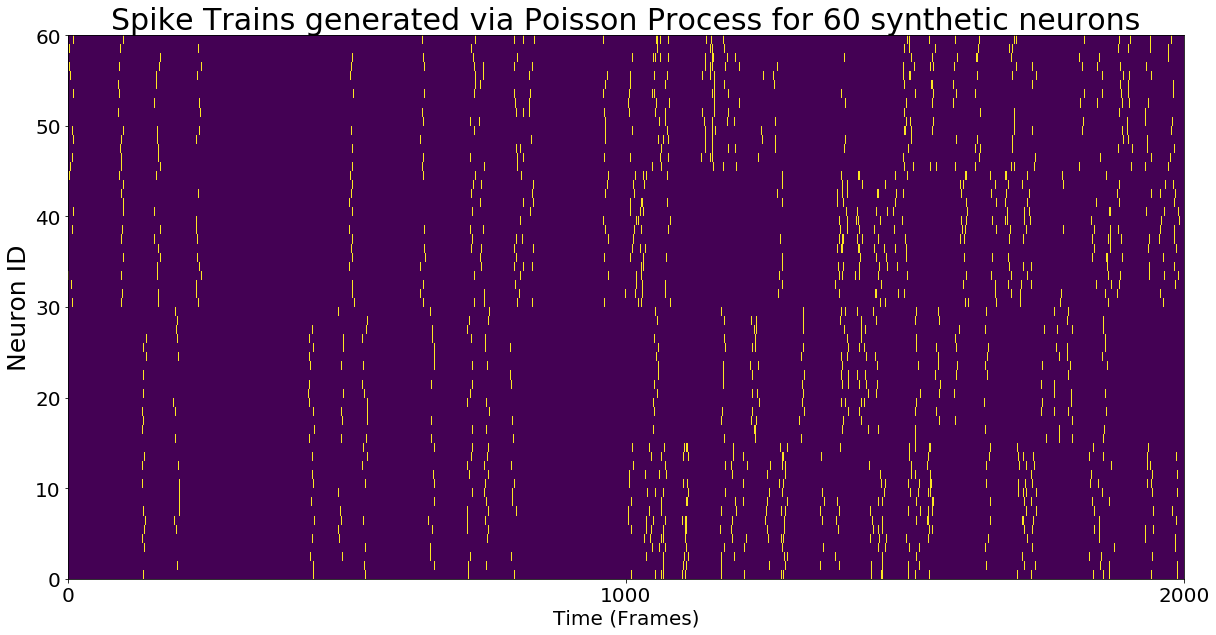

In [68]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,total_duration,0,num_neurons])
ax.set_title('Spike Trains generated via Poisson Process for %d synthetic neurons'%num_neurons, fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(int(total_duration/1000)+1)])
ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)

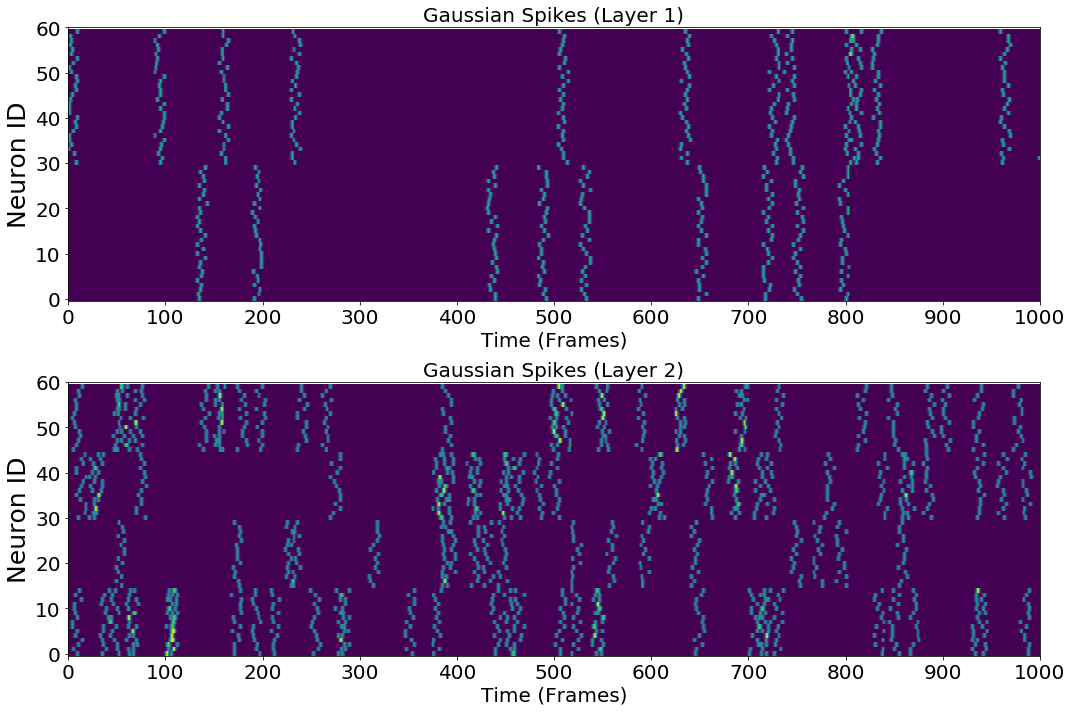

In [69]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,10))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()

In [70]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


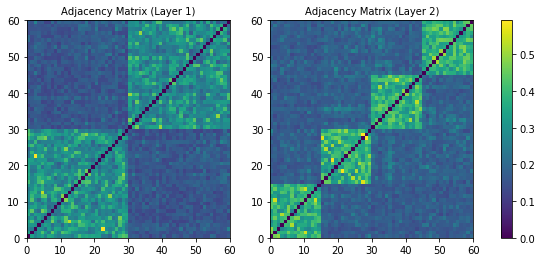

In [71]:
fig,ax = plt.subplots(1,2, figsize = (10,4))
for i in range(2):
    k = ax[i].imshow(adjacency_matrices[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 10)
    ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].tick_params(axis = 'both', labelsize = 10)
cbar = fig.colorbar(k, ax = ax.flat)
cbar.ax.tick_params(labelsize = 10) 

In [74]:
im = Infomap("--two-level --directed")
for i,e in enumerate(adjacency_matrices):## list of length 2 corresponding to the adjacency matrices in each layer
    for j,f in enumerate(e):
        for k in range(len(f)):# f is each row of the adjacency matrix
            s = (i,j)#MultilayerNode(layer_id = i, node_id = j)
            t = (i,k)#MultilayerNode(layer_id = i, node_id = k)
            
            im.add_multilayer_link(s,t,f[k])

##diagonal coupling with interlayer coupling strength 1
for i in range(len(adjacency_matrices)-1):
    for j in range(num_neurons):# number of nodes which is 60 in the multilayer network
        s = (i,j)# MultilayerNode(layer_id = i, node_id = j)
        t = (i+1,j) # MultilayerNode(layer_id = i+1, node_id = j)
        im.add_multilayer_link(s, t, 0.0001)
im.run()

In [75]:
print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

print("\n#layer_id node_id module_id:")
for node in im.nodes:
    print(f"{node.layer_id} {node.node_id} {node.module_id}")

Found 1 modules with codelength: 5.906154587929203

#layer_id node_id module_id:
0 17 1
0 28 1
0 15 1
0 4 1
0 22 1
0 47 1
0 2 1
0 11 1
0 27 1
0 30 1
0 58 1
0 54 1
0 3 1
0 26 1
0 32 1
0 14 1
0 20 1
0 23 1
0 0 1
0 1 1
0 16 1
0 49 1
0 12 1
0 45 1
0 57 1
0 39 1
0 13 1
0 37 1
0 8 1
0 42 1
0 56 1
0 5 1
0 43 1
0 10 1
0 31 1
0 53 1
0 55 1
0 52 1
0 38 1
0 24 1
0 35 1
0 34 1
0 18 1
0 7 1
0 59 1
0 21 1
0 46 1
0 48 1
0 25 1
0 44 1
0 6 1
0 51 1
0 19 1
0 36 1
0 33 1
0 50 1
0 9 1
0 41 1
0 29 1
0 40 1
1 35 1
1 47 1
1 57 1
1 29 1
1 28 1
1 44 1
1 16 1
1 48 1
1 27 1
1 54 1
1 26 1
1 51 1
1 22 1
1 43 1
1 32 1
1 34 1
1 24 1
1 5 1
1 31 1
1 58 1
1 56 1
1 18 1
1 25 1
1 36 1
1 20 1
1 23 1
1 38 1
1 46 1
1 39 1
1 10 1
1 30 1
1 59 1
1 52 1
1 21 1
1 33 1
1 8 1
1 6 1
1 15 1
1 1 1
1 19 1
1 0 1
1 53 1
1 4 1
1 49 1
1 37 1
1 50 1
1 45 1
1 13 1
1 9 1
1 41 1
1 55 1
1 11 1
1 3 1
1 17 1
1 12 1
1 14 1
1 40 1
1 42 1
1 7 1
1 2 1


In [77]:
print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

print("Result")
print("\n#node module")
for node in im.tree:
    if node.is_leaf:
        print(node.node_id, node.module_id)

Found 1 modules with codelength: 5.906154587929203
Result

#node module
17 1
28 1
15 1
4 1
22 1
47 1
2 1
11 1
27 1
30 1
58 1
54 1
3 1
26 1
32 1
14 1
20 1
23 1
0 1
1 1
16 1
49 1
12 1
45 1
57 1
39 1
13 1
37 1
8 1
42 1
56 1
5 1
43 1
10 1
31 1
53 1
55 1
52 1
38 1
24 1
35 1
34 1
18 1
7 1
59 1
21 1
46 1
48 1
25 1
44 1
6 1
51 1
19 1
36 1
33 1
50 1
9 1
41 1
29 1
40 1
35 1
47 1
57 1
29 1
28 1
44 1
16 1
48 1
27 1
54 1
26 1
51 1
22 1
43 1
32 1
34 1
24 1
5 1
31 1
58 1
56 1
18 1
25 1
36 1
20 1
23 1
38 1
46 1
39 1
10 1
30 1
59 1
52 1
21 1
33 1
8 1
6 1
15 1
1 1
19 1
0 1
53 1
4 1
49 1
37 1
50 1
45 1
13 1
9 1
41 1
55 1
11 1
3 1
17 1
12 1
14 1
40 1
42 1
7 1
2 1
